# WB - PD2
### Przemysław Chojecki

In [1]:
import dalex as dx
import pandas as pd
import pickle
import xgboost as xgb

from sklearn.model_selection import train_test_split

## Dane, podział i model

In [2]:
input_df = pd.read_csv('preprocessed_dataset.csv')
y = input_df.loc[:,'Attrition']
X = input_df.drop('Attrition', axis='columns')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14)

In [4]:
model = pickle.load(open( "random_forest_model.p", "rb" ))
explainer = dx.Explainer(model, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 7595 rows 24 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 7595 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f87160b58b0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.248, mean = 0.816, max = 0.948
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.926, mean = 0.0247, max = 0.601
  -> model_info        : package sklearn

A new explainer has been created!


## 1. Dla wybranej obserwacji ze zbioru danych wylicz predykcję modelu

In [38]:
obserwacja = 17
print(explainer.predict(X_test)[obserwacja])
print(y_test.iloc[obserwacja])

0.7299203906237186
0


Dla obserwacji nr $17$ model przewiduje, że na $73\%$ będzie wartość $1$. Okazuje się to błędną predykcją - ten klient opuścił bank. Przyjrzyjmy się, czemu model w tym przypadku się pomylił.

## 2. Dla wybranej obserwacji z punktu 1., wylicz dekompozycję predykcji modelu używając LIME.
Jako, że metoda `LIME` działa losowo, wykonam ją $2$ razy dla danej obserwacji i sprawdzę jak różnią się od siebie tw wywołania.

Próba 1:

In [21]:
pred_surr = explainer.predict_surrogate(X_test.iloc[obserwacja,:], type='lime')

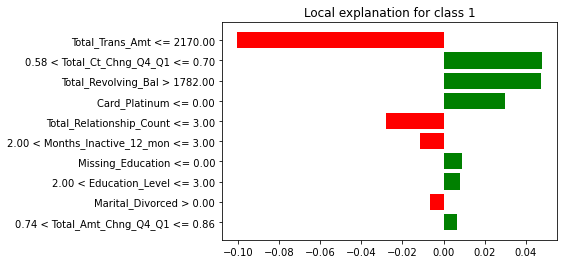

In [23]:
pred_surr.as_pyplot_figure()
print("")

Metoda `LIME` informuje nas, że model skłaniał się ku stwierdzeniu, że klient opuści bank, bo wykonywał mało tranzaskcji na swoim koncie (`Total_Trans_Amt`). Jednakże miał spory `Total_Revolving_Bal`, co oznacza, że w sumie zostawił sobie w tym banku sporo długu. Być może ten dług był zaciągnięty i spłacony dawno, takiej informacji nie mamy w danych. Dodatkowo, model twierdzi, że fakt, że klient ma niższą kartę niż Platynowa (bo platynowa jest najwyższa) oznacza, że raczej zostanie w tym banku. Możemy to interpretować tak, że bogacze posiadający Platynowe karty opuszczają ten bank, bo inny ma dla nich leprzą ofertę.

Próba 2:

In [35]:
pred_surr = explainer.predict_surrogate(X_test.iloc[obserwacja,:], type='lime', seed = 30)

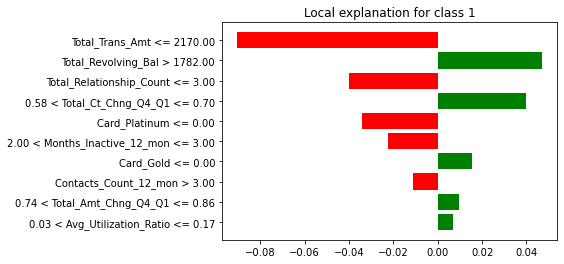

In [36]:
pred_surr.as_pyplot_figure()
print("")

Tym razem `LIME` podaje prawie te same argumenty co przy popszednim wywołaniu, lecz, ku mojemu zdziwieniu, tym razem twierdzi, że fakt, że klient ma niższą kartę niż Platynowa oznacza, że raczej odejdzie z tego banku. Czyli dokładnie odwrotna predykcja na tej samej informacji. Interpretuję to tak, że jest to spowodowane małą liczbą `Card_Platinum = 1` w zbiorze i model ma dużą wariancję na tej zmiennej. Dlatego być może nie powinno się jej brać pod uwagę przy modelowaniu, skoro sakłuca ona działanie modelu? Rozważymy z grupą połączenie kart Platynowych ze Złotymi.

## 3. Porównaj dekompozycję LIME dla różnych obserwacji w zbiorze. Jak stabilne są otrzymane wyjaśnienia?

In [39]:
obserwacja = 117
print(explainer.predict(X_test)[obserwacja])
print(y_test.iloc[obserwacja])

0.8487336523184095
1


Sprawdźmy przewidywania dla obserwacji prawidłowo klasyfikowanej przez model.

In [40]:
pred_surr = explainer.predict_surrogate(X_test.iloc[obserwacja,:], type='lime', seed = 30)

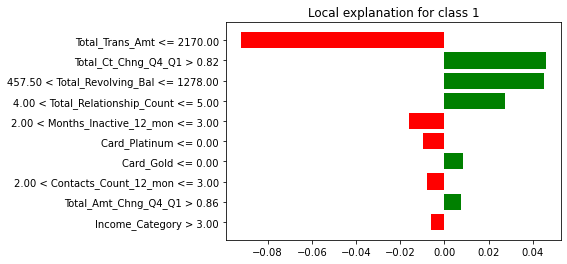

In [41]:
pred_surr.as_pyplot_figure()
print("")

Mimo, że klient nie opuszcza banku i model właśnie to też przewiduje, to najmocniejszy wpłym na predykcję ma kolumna interpretowana przez `LIME` jako mówiąca o tym, że właśnie klient opuści bank. Osoba ta wykonała niewiele tranzakcji w tym banku. Nawet jeśli nie opuszcza tego banku, być może jest to jej drugi bank. Być może dla banku byłoby korzystnym, aby i tak reklamować się u niej, aby przekonać ją, do tego, żeby przelała tu większość zwoich środków.

In [60]:
obserwacja = 217
print(explainer.predict(X_test)[obserwacja])
print(y_test.iloc[obserwacja])

0.461021867033087
0


Sprawdźmy jak `LIME` wytłumaczy predykcję "Raczej opuści bank".

In [61]:
pred_surr = explainer.predict_surrogate(X_test.iloc[obserwacja,:], type='lime', seed = 30)

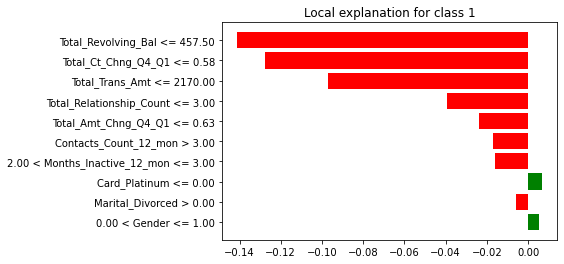

In [62]:
pred_surr.as_pyplot_figure()
print("")

Znów fakt nieposiadania Platynowej karty jest dla modelu mylący. Dodatkowo bycie mężczyzną sugeruje zostanie w banku, co może zaskakiwać, gdyż krąży opinia, że to mężczyźni są bardziej skorzy do zmian.

Sprawdźmy jak model tłumaczy się z najwyżej ocenianej predykcji:

In [73]:
obserwacja = explainer.predict(X_test).argmax()
print(obserwacja)
print(explainer.predict(X_test)[obserwacja])
print(y_test.iloc[obserwacja])

1830
0.945822841440146
1


In [74]:
pred_surr = explainer.predict_surrogate(X_test.iloc[obserwacja,:], type='lime', seed = 30)

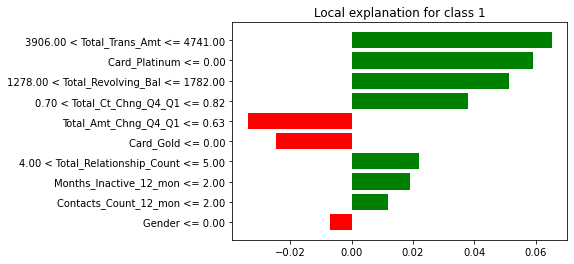

In [75]:
pred_surr.as_pyplot_figure()
print("")

Jak widzimy, `LIME` twierdzi, że były co najmniej $3$ argumenty na opuszczenie banku:
1. `Total_Amt_Chng_Q4_Q1`, czyli znaczący (powyżej $37\%$) spadek używania bankomatów w ciągu ostatniego roku;
2. Brak posiadania Złotej karty;
3. Bycie kobietą.

Co do pierwszego argumentu nie sposób się nie zgodzić, jak klien przestaje używać bankomatów, to racze nas powoli opuszcza. Drugi to znów problem małej próbki w danych co może powodować mylne predykcje. Odnośnie bycia kobietą, to nie wiem, czy to powinno mieć aż takie znaczenie w tej sytuacji. Wymaga to głębrzego zastanowania.

Bardzo jednak dziwi, że fakt nie posiadania Platynowej karty jest baaardzo prze model uznawane jako argument za zostaniem. To naprawdę wygląda, jakby ta kolumna powodowała zamęt w predykcjach. Dziwi równierz to, że spadek liczby tranzakcji na koncie klienta przedonał model do tego, że klient nie opuści banku. Wydaje się, że powinno być odwrotnie. Jest to spadek między pierwszym, a czwartym kwartałem. Oznaczałoby to, że jeśli klient w 3 ostatnich miesiącach roku wykonał o $25\%$ mniej tranzakcji niż w pierwszych 3, to raczej zostanie w banku. W USA trzeba płacić podatki do $15$ kwietnia, więc być może dlatego pierwszy kwartał powoduje większe liczby przelewów niż ostatni, a wtedy $25\%$ to nie byłoby wcale dużo.

# Wnioski
1. Zmienne `Card_Platinum` oraz `Card_Gold` powodują zamieszanie w modelu, prawdopodobnie z powodu ich żadkości. Rozważymy połączenie lub pozbycie się ich;
2. Metoda `LIME` może dawać różne interpretacje w zależności od podanego `seed`a;
3. Posiadanie w zbiorze zmiennej "Płeć" jest ryzykowne, bo model może nauczyć się innych zależności niż od niego oczekujemy.